<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/> 

# TSO JWebbinar Notebook 2: Exploring TSO Products
-----

**Author**: Néstor Espinoza, AURA Assistant Astronomer, NIRISS branch
<br>
**Last Updated**: November 12, 2021
<br>
**Pipeline Version**: x.x.x

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#nirisscaveats)<br>

---

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this notebook we provide material to get started on the exploration of Time-Series Observations (TSO) products; in particular, we focus on outputs from `detector1` and the `spec2` stages of the pipeline.

### 1.2<font color='white'>-</font>Input Simulations<a class="anchor" id="inputs"></a> ###

The input data for this notebook are simulations made by the NIRISS/SOSS team of a transit of WASP-43b. These simulations were made using the [`mirage`](https://mirage-data-simulator.readthedocs.io/en/latest/) simulator. This full dataset can be found [here](https://stsci.box.com/s/fbolnundf2q01yq3fkqpbvswhqch7c91), and includes both the `uncal` products (i.e., the "raw" data) and the data calibrated after the `assignwcs` step of the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html). Note how there are two datasets for each of those set of products, as the JWST products are divided into "segments" dividing the entire exposure into smaller chunks for simple data size purposes.

We will be using products at two different stages of the pipeline, namely:

1. **The Uncalibrated Products**. These correspond to data that have not yet been passed through any of the stages of the pipeline. These have `*uncal.fits` extensions.
3. **The partially Stage 2 Calibrated Products**. These correspond to data that have only been calibrated up to the `assign_wcs` step, with which one can obtain the wavelength map of the spectra. These have `*_1_assignwcsstep.fits` extensions.

These products are downloaded directly from this notebook below. Importantly, these simulations were generated with the following reference files (we will define what these are and why they are important to define below!):

- Reference file for the `SuperBias` step: `jwst_niriss_superbias_0017.fits`.

- Reference file for the `Linearity` step: `jwst_niriss_linearity_0013.fits`.

### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

The [`mirage`](https://mirage-data-simulator.readthedocs.io/en/latest/) simulator is not perfect. Be aware that how close these simulations are to real data is not going to be perfectly known until we obtain on-sky data with JWST. As such, a big disclaimer is that while `mirage` simulations represent a large fraction of the systematics that we expect to see, it is in no way a guarantee that this will be the full picture of what we will _actually_ see on real JWST data.

Also note that time-series systematics have not been added to those simulations. This has been important for previous observatories to consider, and appear due to, e.g., thermal breathing of the instruments, focus changes, etc. 

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we set a number of necessary things in order for the pipeline to run successfully.

First we'll set the CRDS context; this dictates the versions of various pipeline reference files to use. 

Next we'll import the various python packages that we're actually going to use in this notebook, including both generic utility functions and the actual pipeline modules themselves:

In [1]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $HOME/crds_cache
%set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu

# Import all useful libraries:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.interpolate import interp1d

from jwst import datamodels
from astropy.io import fits
from astropy.utils.data import download_file

from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_spec2

env: CRDS_PATH=$HOME/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


3.<font color='white'>-</font>A TSO tour through the `Detector1` stage <a class="anchor" id="setup"></a>
------------------

Here, we will start reducing data and checking the results of this data reduction for TSO's on each step. This will allow us to pick our brains as to how to explore these TSO products, but also, to be careful to be mindful of what the pipeline is actually doing --- and how impactful/important this is for TSOs. 

Here, we will work with only one segment of the data --- on a real data analysis session, we would need to run the same steps on both segments to get the reductions for the entire exposure. We download/load the second segment of this exposure below:

In [2]:
# Download uncal file:
file_link = 'https://stsci.box.com/shared/static/dy0t8hza8tzpoqcdlny54e9y6pbsjctc.fits'
filename = 'WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits'

# Look if the file has been downloaded. If not, do it:
if os.path.exists(filename):
    
    print(filename + ' already exists. Not downloading.')

else:
    
    print('Downloading {}...'.format(filename))
    download_filename = download_file(file_link, cache=True)
    # Rename file:
    os.rename(download_filename, filename)

WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits already exists. Not downloading.


Done! Now let's load the data inside a JWST `datamodel`:

In [3]:
uncal_data = datamodels.open("WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits")

In [4]:
# Cover a bug that exists given the simulated data was created a while ago. This will not be 
# needed to be done on real data, but it's a nice excercise showing how easy it is to deal 
# with JWST datamodels:
uncal_data.meta.dither.dither_points = int(uncal_data.meta.dither.dither_points)

## 3.1 Checking data-quality flags

An important component of any TSO analysis is to flag bad pixels, pixels identified as cosmic rays and/or identify saturated pixels. The former pixels are actually ingested directly by instrument experts on a mask that one loads on the very first step of the JWST pipeline for NIRISS/SOSS data: the `dq_init_step`. Let's run it:

In [5]:
# Let's run the DQ init step --- this will assign DQ flags to our fits uncal file. 
# First, create output directory:

if not os.path.exists('pipeline_outputs_directory'):
    os.mkdir('pipeline_outputs_directory')

# Run step:
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_data, 
                                                            output_dir='pipeline_outputs_directory', 
                                                            save_results=True)

2021-11-19 16:29:57,582 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-11-19 16:29:57,641 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits>,).
2021-11-19 16:29:57,643 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-11-19 16:29:57,676 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2021-11-19 16:29:59,792 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2021-11-19 16:30:06,355 - stpipe.DQInitStep - INFO - Saved model in pipeline_outputs_directory/WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits
2021-

The full list of data quality flags is [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags). For example, pixels with data quality flags of `0` are "normal" pixels and pixels with data quality flags of `2147483648` are reference pixels (more on those in a bit). For all the rest, one has to have some special care. They might be used, but one might want to be careful on how to move forward with them on a case by case basis. 

### 3.1.1 Checking "special" pixels

**Let's assume we want to be extremely conservative, and plot all pixels which are _not_ normal (i.e., having a value other than `0`) or reference pixels (i.e., having a value different than `2147483648`)**. This can be done by extracting the pixel data-quality flags, and using their values as follows: 

In [6]:
# To get the bad pixels, we need to use the "pixeldq" which sets the general data quality for each pixel:
dq_pixels = dq_results.pixeldq

# Identify pixels which are NOT OK and are NOT reference pixels --- we call those "special" pixels:
idx_special_pixels = np.where((dq_pixels != 0)&(dq_pixels != 2147483648))

Let's plot where these are located in the frames:

Text(0.5, 1.0, 'Special pixels in our NIRISS/SOSS SUBSTRIP256 frame:')

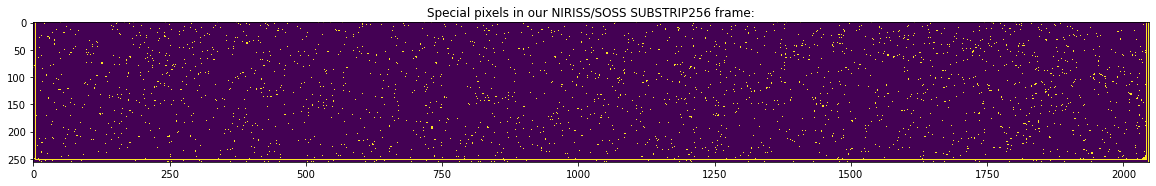

In [7]:
# Let's plot these "special" pixels now:
plt.figure(figsize=(20,5))

# Extract a zero-array with the same shape as the original frames; use first group, first integration as reference:
special_pixels = np.zeros(dq_results.data[0, 0, :, :].shape)

# Identify "special" pixels as ones in this array (initially) zero-array:
special_pixels[idx_special_pixels] = 1.

# Plot them:
im = plt.imshow(special_pixels, interpolation = 'None')
im.set_clim(0,1)
plt.title('Special pixels in our NIRISS/SOSS SUBSTRIP256 frame:')

As can be seen, most of their location are random. There seems to be a set of pixels in the corners that define the boundary with the reference pixels, however, which one should be wary of.

### 3.1.1 Checking saturated pixels

One very important detail in JWST data analysis involves checking which pixels are "saturated" or not. Saturation in the JWST context is an [instrument-by-instrument defined upper signal level](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/tso-saturation) --- but is nonetheless good to know that one can control what is considered saturated or not, and also to check which pixels are identified as saturateed by the pipeline. This is done through the `saturation` step --- the next step of the JWST pipeline for Detector 1. Let's run it:

In [8]:
# Run step:
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results , 
                                                                           output_dir='pipeline_outputs_directory', 
                                                                           save_results=True)

2021-11-19 16:30:06,575 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2021-11-19 16:30:06,641 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits>,).
2021-11-19 16:30:06,643 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-11-19 16:30:06,671 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-11-19 16:30:06,752 - stpipe.SaturationStep - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-11-19 16:30:08,953 - stpipe.SaturationStep - 

The saturation step works by comparing the observed ADU values with the saturation signal-levels defined for each pixel in a reference file. As can be seen above, that reference file is indicated by the line `stpipe.SaturationStep - INFO - Using SATURATION reference file [yourfile]`. In the case of our run at the time of writing, this was the `jwst_niriss_saturation_0011.fits ` file --- but this might change during commisioning or at later stages of pipeline/instrument development and analysis.

Let's have a look at what pixels are indicated as saturated in the first and last groups. This is obtained through the `groupdq` product (which is different from the `pixeldq` used above) --- which are data-quality flags _per group_. Values of `2` mean the pixel is saturated in a given group:

In [9]:
# Extract group data-quality:
dq_groups = saturation_results.groupdq

# Identify saturated pixels in the first and last groups:
idx_sat_pixels_first_group = np.where(dq_groups[0, 0, :, :] == 2)
idx_sat_pixels_last_group = np.where(dq_groups[0, -1, :, :] == 2)

Let's check their location:

Text(0.5, 1.0, 'Saturated pixels on LAST group, first integration:')

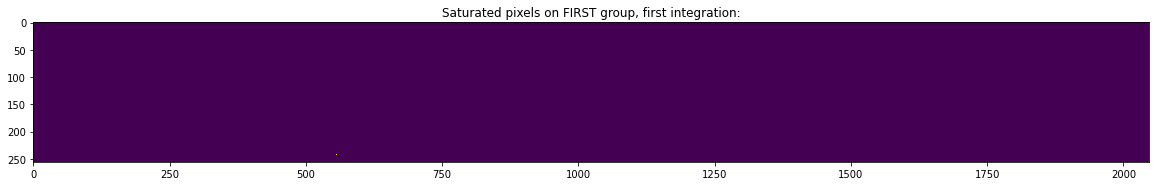

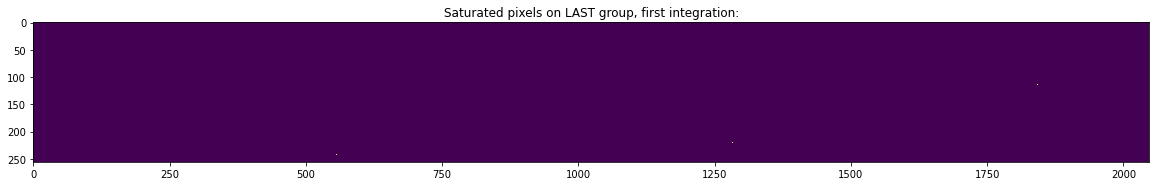

In [10]:
# Extract a zero-array with the same shape as the original frames; use first group, first integration as reference:
saturated_pixels_firstgroup = np.zeros(saturation_results.data[0, 0, :, :].shape)
saturated_pixels_lastgroup = np.zeros(saturation_results.data[0, 0, :, :].shape)

# Identify "saturated" pixels as ones in this array (initially) zero-array:
saturated_pixels_firstgroup[idx_sat_pixels_first_group] = 1.

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturated_pixels_firstgroup, interpolation = 'None')
im.set_clim(0,1)
plt.title('Saturated pixels on FIRST group, first integration:')

# Repeat for last group:
saturated_pixels_lastgroup[idx_sat_pixels_last_group] = 1.

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturated_pixels_lastgroup, interpolation = 'None')
im.set_clim(0,1)
plt.title('Saturated pixels on LAST group, first integration:')

As can be seen, there are not many pixels saturated in the first group --- and pixels saturated in the first group remain saturated in the last group. This is the case for the pixel close to row 250 and column 500.

Now --- why were the pixels identified as saturated? This comes from the `saturation` reference file. You can check which one was used directly from the outputs of the pipeline as follows:



In [11]:
saturation_results.meta.ref_file.saturation.name

'crds://jwst_niriss_saturation_0011.fits'

What does this file looks like? Let's check it out:

In [12]:
# Base directory where reference files are stored (this was defined in the Setup section above:)
base_ref_files = '$HOME/crds_cache/references/jwst/niriss/'

# Read it in:
saturation_ref_file = fits.open(base_ref_files+saturation_results.meta.ref_file.saturation.name[7:])

In [13]:
# Let's print values of the reference file:
print('File values:')
print(saturation_ref_file[1].data[:,:])

print('File shape:')
print(saturation_ref_file[1].data.shape)

File values:
[[73043. 73061. 73037. ... 73824. 74201. 71272.]
 [75241. 75776. 75439. ... 72811. 73969. 74799.]
 [73682. 73697. 72806. ... 72812. 73172. 73125.]
 ...
 [76628. 75464. 76064. ... 75337. 75633. 74924.]
 [74507. 74206. 74122. ... 74548. 73063. 73330.]
 [76464. 76103. 74749. ... 75095. 75570. 72794.]]
File shape:
(2048, 2048)


As you see above, the reference file is a file that, for each pixel, has a value that marks when it's "saturated". This value seems to be around 70,000 counts. Note also that the shape is (2048, 2048) --- the saturation values are defined by the entire full frame of the NIRISS detectors --- this file is simply "cut" to match the dimensions of the subarray (which is a subset of the pixels of the full frame) to define the saturation values for the `SUBSTRIP256` subarray.

Saturation is important because later, when running the ramp-fitting step, saturated groups are ommited from the calculations. You can, of course, manually modify the reference file and define lower count levels for saturation if you want. Alternatively, you can also modify the `groupdq` values directly of the output objects the pipeline gives --- when you ingest them to later steps of the pipeline, they will be propagated accordingly. 

For instance, we could mark all the groups above the third of pixel `(123,123)` as saturated in the first integration as follows:

In [14]:
saturation_results.groupdq[0, 2:, 123, 123] = 2

## 3.2 Reference pixel corrections

After the saturation step, there are two steps to go to get to the step we want to get at --- the `refpix` step. 
We first perform the `superbias` step which removes the detector pedestal from our groups. We are careful to consider that, as it was said in the introduction, the superbias reference file is a special one: the `jwst_niriss_superbias_0017.fits` reference file. We have uploaded this reference file to Box, but this can be obtained directly from CRDS:

In [16]:
# Download uncal file:
ref_filename = 'jwst_niriss_superbias_0017.fits'
download_link = 'https://stsci.box.com/shared/static/1n3etewqfhgbdhd1vpwour3gg3shiisa.fits'

# Look if the file has been downloaded. If not, do it:
if os.path.exists(ref_filename):
    
    print(ref_filename + ' already exists. Not downloading.')

else:
    
    print('Downloading {}...'.format(ref_filename)+' from '+ download_link)
    download_filename = download_file(download_link,
                                      cache=True)
    # Rename file:
    os.rename(download_filename, ref_filename)

In [17]:
# Run superbias step:
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(saturation_results , 
                                                                        output_dir='pipeline_outputs_directory', 
                                                                        override_superbias = ref_filename,
                                                                        save_results=True)

2021-11-19 16:36:00,431 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2021-11-19 16:36:00,504 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_saturationstep.fits>,).
2021-11-19 16:36:00,506 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-11-19 16:36:00,523 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /Users/nespinoza/Documents/Presentations/JWebbinar-TSO/jwebbinar_prep/tso_session/jwst_niriss_superbias_0017.fits
2021-11-19 16:36:12,358 - stpipe.SuperBiasStep - INFO - Saved model in pipeline_outputs_directory/WASP43_NIS_SOSS-seg002_CLEAR_superbiasstep.fits
2021-11-19 16:36:

Let's check how different the superbias and the saturation products look. To this end, let's plot the last group of the first integration:

Text(0.5, 1.0, 'After the Superbias step:')

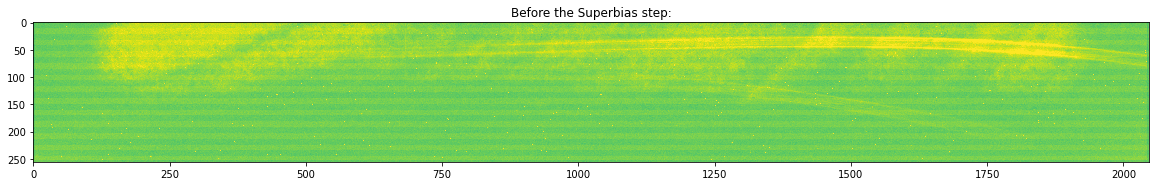

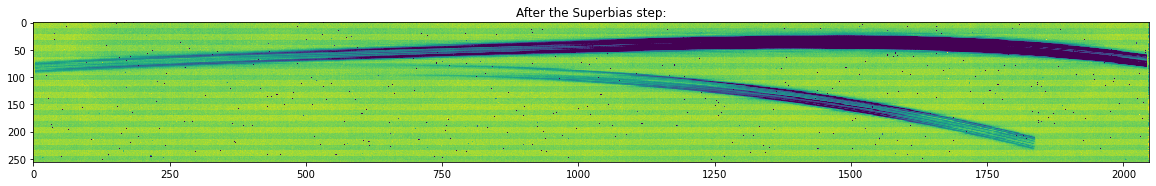

In [31]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturation_results.data[0,-1,:,:] / np.nanmedian(saturation_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the Superbias step:')

# Repeat for last group:
saturated_pixels_lastgroup[idx_sat_pixels_last_group] = 1.

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[0,-1,:,:] / np.nanmedian(superbias_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the Superbias step:')

Wow! That's a huge change. Overall, this looks much better. Let's plot the profiles the column whose index is 1500 to have a closer look:

Text(0, 0.5, 'Counts - Median Counts')

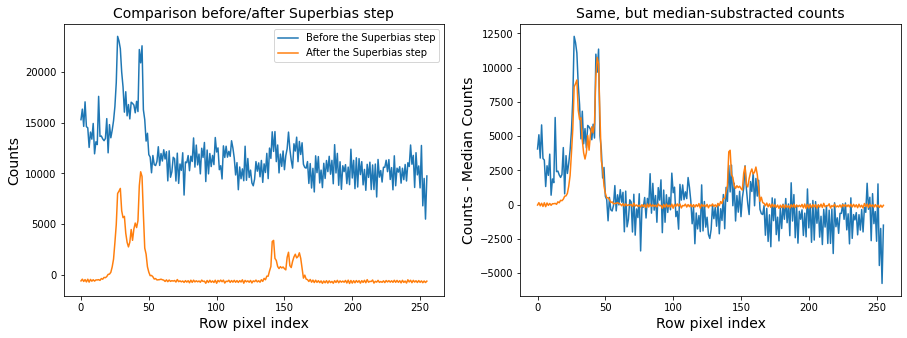

In [84]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(saturation_results.data[0,-1,:,1500], label = 'Before the Superbias step')
ax[0].plot(superbias_results.data[0,-1,:,1500], label = 'After the Superbias step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after Superbias step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(saturation_results.data[0,-1,:,1500] - np.nanmedian(saturation_results.data[0,-1,:,1500]))
ax[1].plot(superbias_results.data[0,-1,:,1500] - np.nanmedian(superbias_results.data[0,-1,:,1500]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)



As can be seen, a ton of structure has been removed. Also, all the pixels seem to be at the same background level. This is a good sign that the Superbias correction has worked correctly. Note the background level is _below_ zero, but this is OK --- group-to-group changes in the overall flux level _are_ expected, and will be removed in the next step --- the `ref_pix` step. Let's apply it and see what comes out of this:

In [54]:
# Run superbias step:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results, 
                                                                     output_dir='pipeline_outputs_directory', 
                                                                     save_results=True)

2021-11-19 16:58:07,512 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2021-11-19 16:58:07,963 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_superbiasstep.fits>,).
2021-11-19 16:58:07,965 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-11-19 16:58:07,980 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2021-11-19 16:58:07,981 - stpipe.RefPixStep - INFO - odd_even_columns = True
2021-11-19 16:58:07,981 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2021-11-19 16:58:07,9

Let's do the same comparison we did above after the Superbias step:

Text(0.5, 1.0, 'After the RefPix step:')

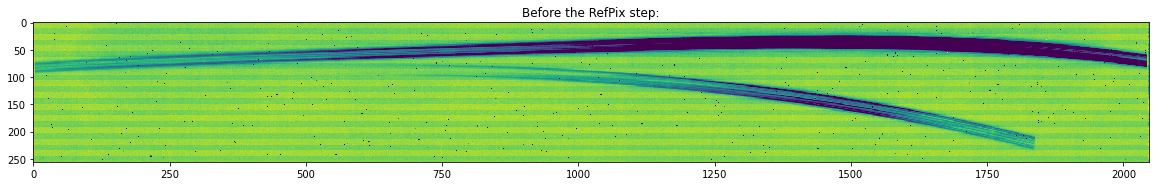

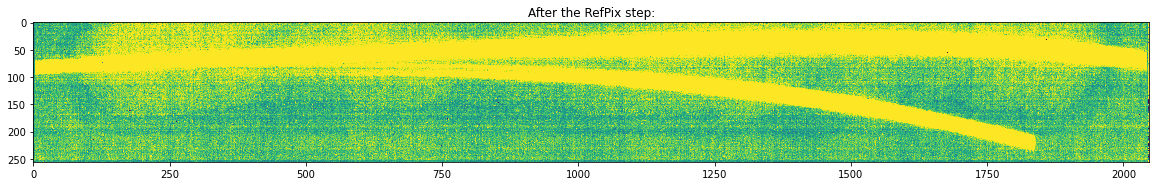

In [55]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[0,-1,:,:] / np.nanmedian(superbias_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the RefPix step:')

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(refpix_results.data[0,-1,:,:] / np.nanmedian(refpix_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the RefPix step:')

Text(0, 0.5, 'Counts - Median Counts')

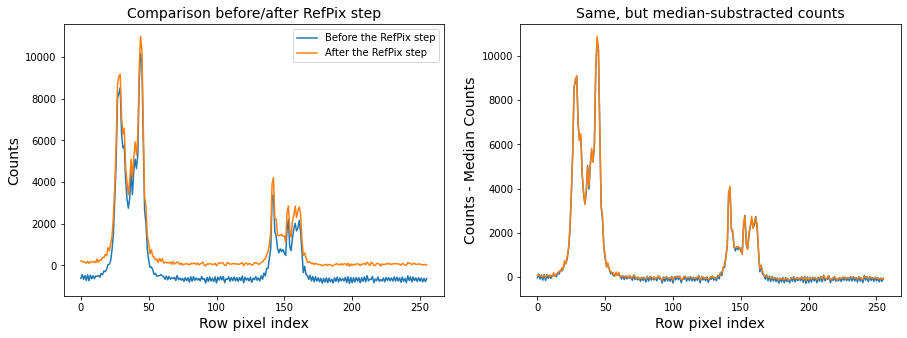

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(superbias_results.data[0,-1,:,1500], label = 'Before the RefPix step')
ax[0].plot(refpix_results.data[0,-1,:,1500], label = 'After the RefPix step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after RefPix step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(superbias_results.data[0,-1,:,1500] - np.nanmedian(superbias_results.data[0,-1,:,1500]))
ax[1].plot(refpix_results.data[0,-1,:,1500] - np.nanmedian(refpix_results.data[0,-1,:,1500]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

Wow! That looks much better. Several things have been removed, including some interesting high-frequency noise happening in the rows. That's the so-called [odd-even effect](https://github.com/ers-transit/hackaton-2021-jwst-pipeline-interaction/blob/master/Interacting%20with%20the%20JWST%20pipeline%20---%20the%20case%20of%20NIRISS.ipynb), that the `refpix` step takes care of efficiently thanks to reference pixels (pixels insenstive to light) in the detector.

As can be seen, most of the detector structure is taken care of up to this point. The backgrounds are now nicely suited slightly _above_ zero, as they should; most detector effects are gone and the group looks much cleaner. It is very instructive to do this kind of visual checks on real data, as they can significantly impact the final achieved S/N if not properly accounted for.

## 3.3 Linearity corrections

Perhaps one of the most important detector effects to be sure is done well is the linearity correction. This can have dramatic effects on pixels attaining high fluxes; on the order of a couple percent on the precision one measures overall flux changes, which is in the order of the variation of e.g., a transit lightcurve. 

Right away from the uncalibrated data, the up-the-ramp samples in JWST detectors are non-linear, with the pixels at the lower fluences being almost linear and pixels near the saturation ranges deviating significantly from this behavior. For our current dataset, however, this is hard to see directly on a given up-the-ramp sample, though. Take, for instance, the pixel located in row index 45 and column index 1500 (which in this example is one of the pixels that attains the larger signals):

Text(0.5, 1.0, 'Counts - Best-fit line')

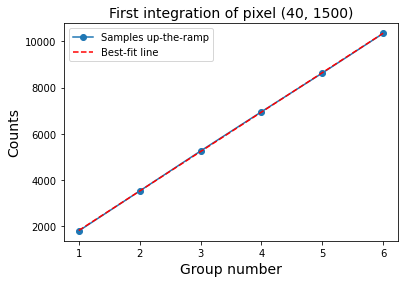

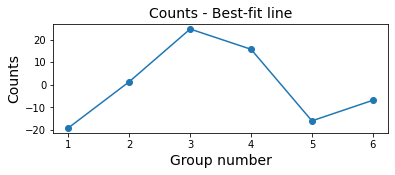

In [99]:
# Fit a line to the data:
coeff = np.polyfit(np.arange(6) + 1, refpix_results.data[0, :, 45, 1500], 1)

plt.figure(figsize = (6,4))
plt.plot(np.arange(6) + 1, refpix_results.data[0, :, 45, 1500], 'o-', label = 'Samples up-the-ramp')
plt.plot(np.arange(6) + 1, np.polyval(coeff, np.arange(6) + 1), 'r--', label = 'Best-fit line')
plt.legend()
plt.xlabel('Group number', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('First integration of pixel (40, 1500)', fontsize = 14)

plt.figure(figsize = (6,2))
plt.plot(np.arange(6) + 1, refpix_results.data[0, :, 45, 1500] - np.polyval(coeff, np.arange(6) + 1), 'o-')
plt.xlabel('Group number', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('Counts - Best-fit line', fontsize = 14)

For these count levels, and for this particular pixel, the detector seems to behave mostly okay, but this is somewhat of a tricky plot. How much of the non-linearity is hidden in the noise? Could this pixel have just be a special one that is behaving OK? We need a population analysis of all the pixels to figure out if everything looks OK. 

One trick to glance at how the linearity of the up-the-ramp samples evolves as one goes up-the-ramp is to note that if the detector is linear, it doesn't matter at which up-the-ramp sample one looks at, the **fluence level should change from group-to-group at _the same rate_ on average**. So one can quickly investigate if linearity is an issue (and if the pipeline is correctly correcting for it) by:

1. Taking the difference in fluence between two groups (say, the last two).
2. Taking the difference in fluence between two _other_ groups (say, the first two).
3. Take the ratio between those differences.

If the detector is linear, then all the pixels should fall around a ratio of 1. Do they? Let's try this experiment out. Let's first take the difference of the last two and first two groups for all the pixels of all the integrations --- then take the ratio of those:

In [100]:
last_pair = refpix_results.data[:, 5, :, :] - refpix_results.data[:, 4, :, :]
first_pair = refpix_results.data[:, 1, :, :] - refpix_results.data[:, 0, :, :]

In [102]:
ratio = last_pair / first_pair

Let's now flatten those arrays and plot them as a function of total fluence at the very last group. If linearity weren't an issue, all of these should line around 1:

In [105]:
flattened_ratio = ratio.flatten()
flattened_fluences = refpix_results.data[:, 5, :, :].flatten()

Text(0.5, 1.0, 'No linearity correction')

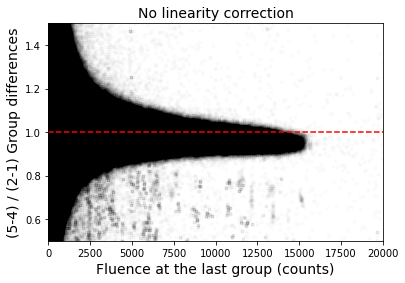

In [118]:
plt.figure(figsize = (6,4))
plt.plot(flattened_fluences, flattened_ratio, '.', alpha = 0.01, color = 'black')
plt.plot([0,20000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,20000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(5-4) / (2-1) Group differences', fontsize = 14)
plt.title('No linearity correction', fontsize = 14)

Indeed, the data does _not_ line up around 1. So linearity _is_ an issue!

The next step in the pipeline, the `linearity` step, corrects for this effect. We now correct for it and make sure we use the correct reference file that was used to generate our data:

In [71]:
# Download uncal file:
ref_filename = 'jwst_niriss_linearity_0013.fits'
download_link = 'https://stsci.box.com/shared/static/vwkayh6no08kjkxeqktimmvrctambdto.fits'

# Look if the file has been downloaded. If not, do it:
if os.path.exists(ref_filename):
    
    print(ref_filename + ' already exists. Not downloading.')

else:
    
    print('Downloading {}...'.format(ref_filename)+' from '+ download_link)
    download_filename = download_file(download_link,
                                      cache=True)
    # Rename file:
    os.rename(download_filename, ref_filename)

In [73]:
# Run superbias step:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(refpix_results, 
                                                                        output_dir='pipeline_outputs_directory', 
                                                                        override_linearity = ref_filename,
                                                                        save_results=True)

2021-11-19 17:15:33,187 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2021-11-19 17:15:33,698 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_refpixstep.fits>,).
2021-11-19 17:15:33,700 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-11-19 17:15:33,715 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/nespinoza/Documents/Presentations/JWebbinar-TSO/jwebbinar_prep/tso_session/jwst_niriss_linearity_0013.fits
2021-11-19 17:15:33,937 - stpipe.LinearityStep - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-11

All right, let's try the same experiment but on the corrected data:

In [113]:
corrected_last_pair = linearity_results.data[:, 5, :, :] - linearity_results.data[:, 4, :, :]
corrected_first_pair = linearity_results.data[:, 1, :, :] - linearity_results.data[:, 0, :, :]
corrected_ratio = corrected_last_pair / corrected_first_pair

Let's plot:

In [114]:
flattened_corrected_ratio = corrected_ratio.flatten()
flattened_corrected_fluences = linearity_results.data[:, 5, :, :].flatten()

Text(0.5, 1.0, 'After linearity correction')

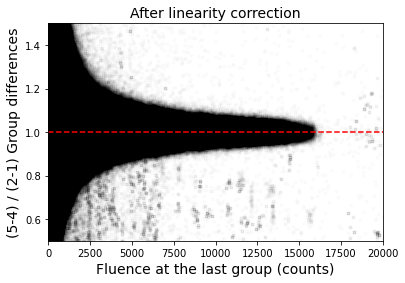

In [119]:
plt.figure(figsize = (6,4))
plt.plot(flattened_corrected_fluences, flattened_corrected_ratio, '.', alpha = 0.01, color = 'black')
plt.plot([0,20000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,20000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(5-4) / (2-1) Group differences', fontsize = 14)
plt.title('After linearity correction', fontsize = 14)

That looks **much** better. Plots like this will be fundamental to make with real data, to make sure linearity was properly corrected and it is not an issue with the current dataset. If it is, say, for the very last groups, one could follow a strategy in which one marks those last groups as saturated pixels --- so future pipeline steps don't consider those in the analysis. Better linearity solutions could also be a possible solution on its own for problems like that.